## Topic Model and LDA in Rental Cars Reviews

In [23]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [110]:
reviews = pd.read_csv('rental_car_reviews.csv')

In [111]:
reviews.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,kms_G9eUBjP41WNcilV-BQ,Bbar1EB4JEviStEAqUEFOg,2NsEac9xCBI05bo5l4yI7Q,3,16,10,15,Review #189 - 2016\n\nWe arrived at Hertz at a...,9/18/16 16:36
1,fInMTob45HEXMD5w6EU1OA,wkL-vtKiksfYNRiRPRFvFg,LHXisknIbUy_XtdEQc7x9w,1,7,4,1,RUN RUN RUN!!! This is a sham up one side and ...,4/15/15 5:56
2,q657lC-g6BNC5sb355g1tQ,a0WsTTJAEqsZ4oNNIVn_lA,LHXisknIbUy_XtdEQc7x9w,1,2,1,2,I will never rented from them.\nMy friend lost...,11/14/13 0:47
3,LdJ3Ktxs0SaPuLxMpxsCuQ,6-nJnTCI8zCMwxHrRHeAVA,2NsEac9xCBI05bo5l4yI7Q,1,2,0,0,My wife and I flew out to Vegas for the 3-Day ...,2/21/13 21:01
4,89VEv6_a1xGLMwyFmyI17A,_-OfDLQDrShVuMNq9H1mJQ,y-mHecGBw8oFGKueVwTOJA,5,0,0,0,Check in and check out was quick and efficient...,2/1/18 16:01


In [112]:
reviews.shape

(7789, 9)

**Data Cleaning**

In [113]:
#check empty review
reviews['text'].isnull().sum()

0

**Check and Remove short reviews**

Remove reviews where length of words < 5

In [114]:
reviews['lenText'] = reviews['text'].str.split().str.len()

In [115]:
reviews = reviews.query("lenText >= 5").reset_index(drop = True)

In [116]:
#use for join later if needed
reviews['Document_No'] = np.arange(0, len(reviews))

In [118]:
#remove 3 rows
reviews.shape

(7786, 11)

In [119]:
reviews['text'][1]

'RUN RUN RUN!!! This is a sham up one side and down the other!! We rented an economy car, like we have 40 times (we are locals). We prepaid through carrentals.com. It CLEARLY STATES on the agreement...UNLIMITED MILES.....I drop my husband off to get our PREPAID RENTAL CAR from EZ SLEEZY CAR RENTALS OF LAS VEGAS! When hubby gets to the counter...GUESS WHAT...she said YOU ARE LOCALS... you need to bring a bill from home to PROVE WHERE YOU LIVE...and you only get 150 miles per day and you need to pay a big fat deposit and and and..IT CLEARLY SAYS ON CONTRACT....unlimited miles...paid in full...The rude B$TCH at the counter was a horrible wench with a horrible attitude...she was just a nasty person.So my husband walked over to HERTZ...rented a car....paid and because it was in person they did a 200.00 hold (which is fine) it was 20.00 more for 1 day less than EZ SHIT HOLE NASTY CAR SCAM NOT RENT AL. Then on the contract it says NO REFUNDS NO MATTER WHAT....   SERIOUSLY!?  They broke the co

In [120]:
# Remove punctuation
reviews['reviewText_clean'] = reviews['text'].map(lambda x: re.sub('["#$;:(),\!\'?-]', '', x))
#replace rn with space
reviews['reviewText_clean'] = reviews['reviewText_clean'].map(lambda x: re.sub(r'\r\n|\r|\n|\.', ' ', x))
#removed one space with one space
reviews['reviewText_clean'] = reviews['reviewText_clean'].map(lambda x: re.sub(r'\s+', ' ', x))

#lower case
reviews['reviewText_clean'] = reviews['reviewText_clean'].map(lambda x: x.lower())

In [121]:
reviews['reviewText_clean'][0]

'review 189 2016 we arrived at hertz at around 215 pm on aug 24th and was able to get our rental in about 2025 minutes the pick up process is pretty simple you can either go to a customer service rep or use their selfserve kiosk which is what i ended up doing the lady who was assisting me on the kiosk phone was pretty friendly but she was doing a lot of upsell so it was kind of bothersome i didnt need a bigger car than an economy size since there was only 2 of us i understand that they probably work off of commission but sometimes its unnecessary to try and convince you to get something that you dont need the return process was pretty quick and easy as well i ended up getting charged for an extra day because i brought the car back 1 5 hours after the pick up time since my flight didnt leave until 8 pm too bad they dont have a grace period for regular customers other than that the car was fine i didnt get anything fancy just a kia so nothing much to write aboutother than the fact that i

In [122]:
#get list of stopwords
stop_words = stopwords.words('english')
#throw car and rental out because reviews are clearly about these
stop_words.extend(['from', 'subject', 're', 'edu', 'use', "would", "wa", "car", "rental"])

**Lemmatize, sent to words, and remove stopwords**

In [123]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [124]:
reviews['lemmatext'] = reviews['reviewText_clean'].apply(lemmatize_text)

In [125]:
data = reviews['lemmatext'].values.tolist()
data_words = list(sent_to_words(data))

In [126]:
# remove stop words
data_words = remove_stopwords(data_words)

**Bigrams**

In [127]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [128]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

# See trigram example
data_words = bigram_mod[data_words]

**Word Frequency Analysis** - check if we can remove unnecessary words for this context

In [129]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [130]:
wordcount = pd.DataFrame(flatten(data_words))
wordcount.columns = ["word"]

In [131]:
wordcount["word"].value_counts().head(15)

get          5406
time         4187
service      4012
customer     3698
line         3691
company      3535
day          3390
rent         3263
one          3233
got          2994
back         2953
told         2935
insurance    2869
said         2844
vega         2739
Name: word, dtype: int64

In [132]:
wordcount["word"].value_counts().tail(15)

awy              1
pulp             1
disagree         1
undersupplies    1
vying            1
effed            1
blanket          1
elsewherelike    1
oatman           1
depositing       1
whattttt         1
sd               1
cliche           1
dident           1
midweek          1
Name: word, dtype: int64

In [133]:
# make dictionary and corpus 
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [134]:
# run LDA model
num_topics = 15
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       workers = 4)

In [135]:
lda_model.show_topics()

[(10,
  '0.049*"cash" + 0.038*"wallet" + 0.030*"visa" + 0.027*"dad" + 0.027*"jump" + 0.025*"unhappy" + 0.024*"coupon" + 0.020*"voucher" + 0.016*"pre_paid" + 0.014*"furthermore"'),
 (0,
  '0.027*"machine" + 0.026*"lax" + 0.016*"manner" + 0.016*"single" + 0.016*"count" + 0.016*"nissan" + 0.013*"clue" + 0.012*"regard" + 0.012*"prefer" + 0.011*"pleased"'),
 (2,
  '0.043*"dirty" + 0.041*"smell" + 0.036*"filthy" + 0.032*"smelled" + 0.029*"inside" + 0.027*"smoke" + 0.021*"son" + 0.017*"seat" + 0.015*"yaris" + 0.014*"window"'),
 (12,
  '0.017*"wednesday" + 0.015*"pain" + 0.013*"sat" + 0.013*"ugh" + 0.012*"coffee" + 0.011*"lowest" + 0.011*"faster" + 0.010*"rode" + 0.009*"canceling" + 0.008*"lined"'),
 (7,
  '0.014*"get" + 0.011*"like" + 0.009*"time" + 0.009*"dont" + 0.008*"one" + 0.008*"didnt" + 0.007*"insurance" + 0.007*"back" + 0.007*"go" + 0.007*"im"'),
 (3,
  '0.060*"shuttle" + 0.043*"airport" + 0.028*"get" + 0.025*"take" + 0.016*"center" + 0.015*"minute" + 0.014*"bus" + 0.014*"location" + 

In [136]:
pyLDAvis.enable_notebook()

In [137]:
vis = gensimvis.prepare(lda_model,corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.238826 -0.051348       1        1  23.717668
8      0.245453 -0.006084       2        1  21.687574
6      0.262469 -0.020935       3        1  12.868837
4      0.229925  0.026189       4        1  10.664893
9      0.258221 -0.004423       5        1  10.358108
3      0.212907 -0.048136       6        1   8.294264
5      0.184393 -0.034802       7        1   6.499240
11    -0.072133  0.204764       8        1   1.728991
14    -0.130631  0.294396       9        1   1.065784
2     -0.216459 -0.110893      10        1   0.788043
13    -0.217359 -0.048519      11        1   0.701797
1     -0.246384 -0.058174      12        1   0.541493
12    -0.238123 -0.052723      13        1   0.444638
0     -0.254295 -0.043167      14        1   0.355472
10    -0.256809 -0.046145      15        1   0.283197, topic_info=            Term         Freq        Total Category  logprob  loglift
466       dollar  1820.000000  1820.000000  Default  30.0000  30.0000
241         line  3903.000000  3903.000000  Default  29.0000  29.0000
4879         fox  1187.000000  1187.000000  Default  28.0000  28.0000
296      shuttle  2475.000000  2475.000000  Default  27.0000  27.0000
562      vehicle  1916.000000  1916.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2471    hot_wire     2.734726     3.649862  Topic15  -6.2402   5.5781
4270      kindly    15.274113    26.679303  Topic15  -4.5201   5.3091
924      utilize     4.367528     7.229815  Topic15  -5.7720   5.3628
2986  mastercard     6.007919    12.956527  Topic15  -5.4531   5.0983
2322        file     4.838983    55.836683  Topic15  -5.6695   3.4211

[921 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4772      8  0.964893         ability
2685     10  0.988566  absolute_worst
3678     12  0.914366         abusive
898       2  0.889237         account
898       6  0.031533         account
...     ...       ...             ...
1681     12  0.041169            yelp
4047     14  0.903119             yep
2857      1  0.966963            youd
2308      1  0.987357           youve
4105      8  0.963480   zion_national

[2105 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 7, 5, 10, 4, 6, 12, 15, 3, 14, 2, 13, 1, 11])

**Compute perplexity and coherence score**

In [138]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.08926989248882

Coherence Score:  0.4654545336032163


**Finding the dominant topic in each sentence**

In [139]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.6897,"get, like, time, dont, one, didnt, insurance, ...","[review, 189, 2016, we, arrived, at, hertz, at..."
1,1,9.0,0.4415,"place, rent, dont, reservation, service, get, ...","[run, run, run, this, is, a, sham, up, one, si..."
2,2,8.0,0.5619,"insurance, day, charge, told, company, said, c...","[i, will, never, rented, from, them, my, frien..."
3,3,7.0,0.3142,"get, like, time, dont, one, didnt, insurance, ...","[my, wife, and, i, flew, out, to, vega, for, t..."
4,4,4.0,0.6340,"great, service, experience, vega, rent, time, ...","[check, in, and, check, out, wa, quick, and, e..."
5,5,6.0,0.2818,"line, hour, wait, people, get, minute, time, c...","[made, my, online, reservation, with, hertz, a..."
6,6,3.0,0.3249,"shuttle, airport, get, take, center, minute, b...","[wow, location, is, horrible, scary, dungeon, ..."
7,7,3.0,0.4892,"shuttle, airport, get, take, center, minute, b...","[a, very, streamlined, process, from, baggage,..."
8,8,4.0,0.3951,"great, service, experience, vega, rent, time, ...","[im, honestly, shocked, this, location, doe, n..."
9,9,3.0,0.9003,"shuttle, airport, get, take, center, minute, b...","[this, place, wa, awesome, it, like, a, little..."


In [140]:
plt.rcParams["figure.figsize"] = (12,6)

Text(0.5, 1.0, 'Count Dominant Topic Across Document')

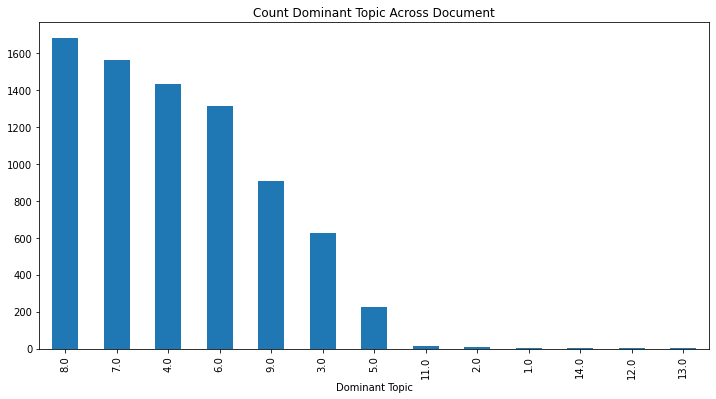

In [141]:
fig = df_dominant_topic.groupby('Dominant_Topic')['Dominant_Topic'].agg(['count']).sort_values("count", ascending = False).plot(kind = 'bar', legend = False)
plt.xlabel("Dominant Topic")
plt.title("Count Dominant Topic Across Document")

**Find the most representative document for each topic**

In [167]:
# Group top 5 sentences under each topic
df_lda_sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    df_lda_sent_topics_sorted = pd.concat([df_lda_sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
    

df_lda_sent_topics_sorted.reset_index(drop=True, inplace=True)

df_lda_sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

df_lda_sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.9887,"fox, garbage, watched, fair, cuz, apply, needl...","[apos, fazer, muita, pesquisa, e, mesmo, lendo..."
1,2.0,0.8948,"dirty, smell, filthy, smelled, inside, smoke, ...","[da, car, rental, center, ist, vom, mccarran, ..."
2,3.0,0.9867,"shuttle, airport, get, take, center, minute, b...","[it, wa, my, first, time, to, rent, a, car, in..."
3,4.0,0.9689,"great, service, experience, vega, rent, time, ...","[this, wa, a, great, place, to, rent, a, car, ..."
4,5.0,0.8026,"got, back, went, said, gas, upgrade, told, did...","[very, nice, car, very, clean, window, clean, ..."
5,6.0,0.9816,"line, hour, wait, people, get, minute, time, c...","[i, will, never, rent, from, advantage, again,..."
6,7.0,0.9852,"get, like, time, dont, one, didnt, insurance, ...","[this, is, is, response, to, peter, m, who, wa..."
7,8.0,0.9900,"insurance, day, charge, told, company, said, c...","[i, booked, a, rental, car, using, orbitz, the..."
8,9.0,0.9717,"place, rent, dont, reservation, service, get, ...","[i, wish, i, could, give, them, zero, star, wo..."
9,11.0,0.8833,"vehicle, hertz, national, member, location, av...","[how, is, it, possible, that, you, can, be, a,..."
